# Spotify Final Project - Emily Xie EDA
### Milestone 3: EDA and Baseline Model
### Austin Rochon, Emily Xie, and Mark Lock

In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold



## Setting up to query Google BigQuery

Since the data set is 70 million rows, and cannot all be easily managed on our local machines, we've decided to use GCP (Google Cloud Developer) platform to help us manage our data. First, we uploaded the CSVs into a private GCP  storage bucket, and from there sent the data to BigQuery, GCP's distributed database, which will allow us to query the data however we like.

Here's the interface (you need access): https://console.cloud.google.com/bigquery?folder=&organizationId=&project=spotted-d&p=spotted-d&d=playlist_songs&t=playlist_songs&page=table

From here, we can retrieve, query, join, and manipulate the entirety of the dataset however we like. Please follow the instructions below in this notebook to set up your Jupyter so that it can query directly from GCP. 

### Setup Instructions

The following setup should take just a few minutes.

#### 1. Create a service account. 
Go to https://console.cloud.google.com/iam-admin/serviceaccounts?project=spotted-d. Once you are on this page, go to the "actions" tab, where there will be a drop-down indicated by three dots on the right-most part of the corresponding account. Click "Create Key" which will download a key for you somewhere on your local machine. Save it somewhere safe. :-)  

If you plan to store it on this git project, make sure to put in a folder that is git-ignored so that we don't push it up to Github. I actually created a .gitignore file on this branch. If you create a directory called "config" under the top-level directory of this repository and stick your service key in there, it should be automatically ignored. Ask me if you want any help.

#### 2. Set up implicit authentication with gCloud
If you are using Mac, just run this on your command line:

`export GOOGLE_APPLICATION_CREDENTIALS="[PATH]"`

If you are using Windows:

`$env:GOOGLE_APPLICATION_CREDENTIALS="[PATH]"`

For more info, see below:

https://cloud.google.com/docs/authentication/getting-started#auth-cloud-implicit-python

#### 3. Install Google Cloud Big Query Pandas python package.

Run this on your terminal:

`pip install --upgrade google-cloud-bigquery[pandas]`

For more on the above two steps, you can check out the GCP documentation: https://cloud.google.com/bigquery/docs/visualize-jupyter

#### Run this cell to load google cloud bigquery:

In [5]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=""

In [6]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


#### Now, you can query your data. Next to "bigquery", write the name of the variable you'd like to save your query results into.

In [7]:
%%bigquery playlist_data
select *
from playlist_songs.playlists_songs_ordered_pid
order by pid
limit 100000

#### You'll notice that it automatically saves to a Pandas dataframe for you

In [8]:
len(playlist_data)

100000

## EDA

In [9]:
playlist_data.head()

,unique_pid,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,album_name,index,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,trackid
0,998100,100,50,Cake,spotify:track:0qgiFuYhYuwtFXEwYakddE,spotify:artist:6A43Djmhbe9100UwnI7epV,I Will Survive,spotify:album:57lJNxlrPSin9SySEnerNb,Fashion Nugget,11.0,...,0.901,95.732,audio_features,0qgiFuYhYuwtFXEwYakddE,spotify:track:0qgiFuYhYuwtFXEwYakddE,https://api.spotify.com/v1/tracks/0qgiFuYhYuwt...,https://api.spotify.com/v1/audio-analysis/0qgi...,310600.0,4.0,spotify:track:0qgiFuYhYuwtFXEwYakddE
1,997100,100,9,The Rolling Stones,spotify:track:0wzABO1igQsSy8cQ7dIeHK,spotify:artist:22bE4uQ6baNwSHPVcDxLCe,Paint It Black,spotify:album:19MOC02Ei3l2SalGUGWozw,Aftermath,86.0,...,0.569,158.810,audio_features,0wzABO1igQsSy8cQ7dIeHK,spotify:track:0wzABO1igQsSy8cQ7dIeHK,https://api.spotify.com/v1/tracks/0wzABO1igQsS...,https://api.spotify.com/v1/audio-analysis/0wzA...,202267.0,4.0,spotify:track:0wzABO1igQsSy8cQ7dIeHK
2,994100,100,22,Sum 41,spotify:track:4dzOxPZFYX77xpMwv4EhnO,spotify:artist:0qT79UgT5tY4yudH9VfsdT,Fat Lip,spotify:album:47wh50aG3MIgDpsMe5B7n7,"All Killer, No Filler",55.0,...,0.641,196.444,audio_features,4dzOxPZFYX77xpMwv4EhnO,spotify:track:4dzOxPZFYX77xpMwv4EhnO,https://api.spotify.com/v1/tracks/4dzOxPZFYX77...,https://api.spotify.com/v1/audio-analysis/4dzO...,178267.0,4.0,spotify:track:4dzOxPZFYX77xpMwv4EhnO
3,999100,100,34,Adele,spotify:track:2rnvHrNnkWMcAkl4S1WlRg,spotify:artist:4dpARuHxo51G3z768sgnrY,Lovesong,spotify:album:1azUkThwd2HfUDdeNeT147,21,15.0,...,0.329,116.925,audio_features,2rnvHrNnkWMcAkl4S1WlRg,spotify:track:2rnvHrNnkWMcAkl4S1WlRg,https://api.spotify.com/v1/tracks/2rnvHrNnkWMc...,https://api.spotify.com/v1/audio-analysis/2rnv...,316440.0,4.0,spotify:track:2rnvHrNnkWMcAkl4S1WlRg
4,999100,100,50,Demi Lovato,spotify:track:56twMOlq9DJc3EgpVUVIrW,spotify:artist:6S2OmqARrzebs0tKUEyXyp,Stone Cold,spotify:album:3HV3ecmJJ2GmHM93vVVKXF,Confident,7.0,...,0.327,139.321,audio_features,56twMOlq9DJc3EgpVUVIrW,spotify:track:56twMOlq9DJc3EgpVUVIrW,https://api.spotify.com/v1/tracks/56twMOlq9DJc...,https://api.spotify.com/v1/audio-analysis/56tw...,191308.0,3.0,spotify:track:56twMOlq9DJc3EgpVUVIrW


In [10]:
playlist_data.dtypes

unique_pid            int64
pid                   int64
pos                   int64
artist_name          object
track_uri            object
artist_uri           object
track_name           object
album_uri            object
album_name           object
index               float64
danceability        float64
energy              float64
key                 float64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
type                 object
id                   object
uri                  object
track_href           object
analysis_url         object
duration_ms         float64
time_signature      float64
trackid              object
dtype: object

Most popular tracks

In [ ]:
counts_by_track = playlist_data.groupby(["trackid", "track_name", "artist_name"]).count()
counts_by_track["count_freq"] = counts_by_track["pid"]
counts_by_track[["count_freq"]].sort_values(by="count_freq", ascending=False)


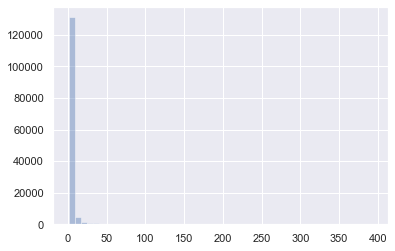

In [49]:
sns.set(color_codes=False)
sns.distplot(counts_by_track[["count_freq"]], kde=False);

Now, let's start examining our acoustic data

In [11]:
# https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-pandas
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
playlist_numeric = playlist_data.select_dtypes(include=numerics)
playlist_numeric["trackid"] = playlist_data["trackid"]
playlist_numeric = playlist_numeric.set_index("trackid")
playlist_numeric.head()

/Users/austinrochon/Documents/6.Harvard/harvard-coursework/ac209a/labs/lab1/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,unique_pid,pid,pos,index,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
trackid,,,,,,,,,,,,,,,,,
spotify:track:0qgiFuYhYuwtFXEwYakddE,998100,100,50,11.0,0.507,0.683,7.0,-8.079,1.0,0.0316,0.303000,0.000132,0.1420,0.901,95.732,310600.0,4.0
spotify:track:0wzABO1igQsSy8cQ7dIeHK,997100,100,9,86.0,0.482,0.800,11.0,-9.278,0.0,0.0916,0.056900,0.002230,0.3870,0.569,158.810,202267.0,4.0
spotify:track:4dzOxPZFYX77xpMwv4EhnO,994100,100,22,55.0,0.405,0.910,9.0,-5.234,1.0,0.1280,0.000499,0.000000,0.0739,0.641,196.444,178267.0,4.0
spotify:track:2rnvHrNnkWMcAkl4S1WlRg,999100,100,34,15.0,0.690,0.373,0.0,-9.454,0.0,0.0284,0.722000,0.001030,0.1110,0.329,116.925,316440.0,4.0
spotify:track:56twMOlq9DJc3EgpVUVIrW,999100,100,50,7.0,0.412,0.472,8.0,-7.543,1.0,0.0476,0.475000,0.000000,0.0974,0.327,139.321,191308.0,3.0


In [12]:
# drop our non-song-related numeric data
playlist_numeric = playlist_numeric.drop(["index","pid", "pos", "unique_pid"], axis=1)

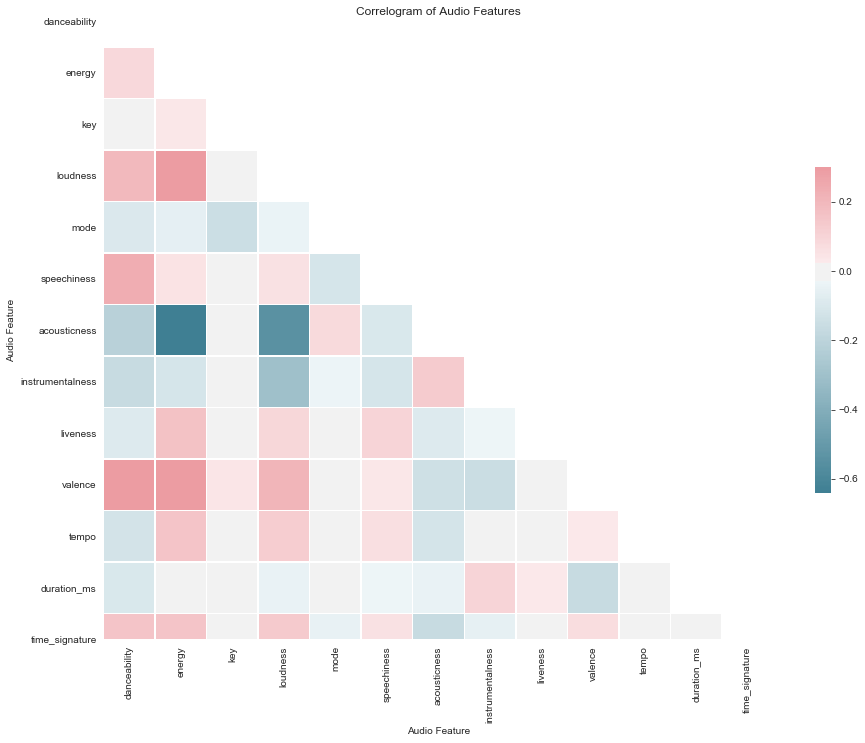

In [13]:
# Correlation matrix
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set_style("whitegrid", {'axes.grid' : False})

# Compute the correlation matrix
corr = playlist_numeric.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Set up labels
plt.xlabel("Audio Feature")
plt.ylabel("Audio Feature")
plt.title("Correlogram of Audio Features")
plt.show()

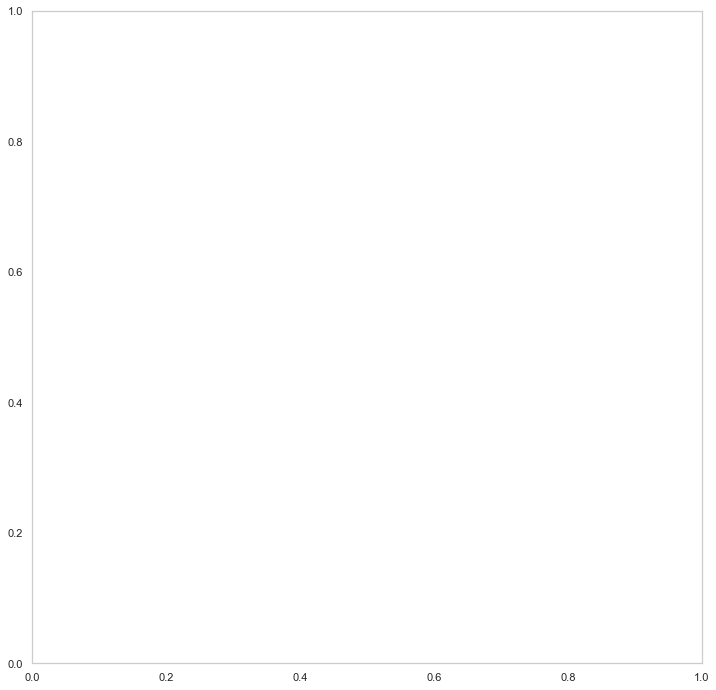

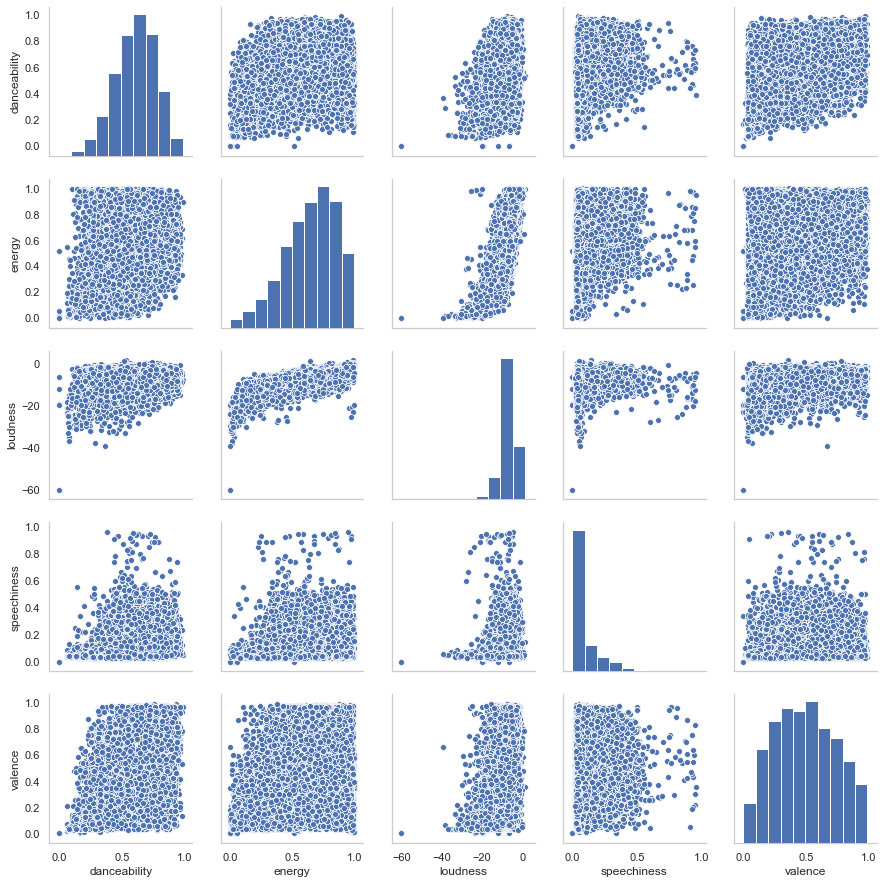

In [65]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Pairplot
pp = sns.pairplot(playlist_numeric.sample(frac=0.05)[["danceability", "energy", "loudness", "speechiness", "valence"]])

# # Set up labels
# plt.xlabel("Audio Feature")
# plt.ylabel("Audio Feature")
# plt.title("Pairwise Relationships Between Select Audio Features");

## Baseline Model

#### K-Means for labeling

Okay, let's try to group these songs into clusters, using their audio properties. First, we need to normalize our data

In [14]:
def normalize(df, scalar, features):
    # Split df into features and non-features
    non_feature_df = df[df.columns.difference(features)]
    feature_df = df[features]
    
    # Scale the features
    np_transform = scalar.transform(feature_df)
    df_transform = pd.DataFrame(np_transform, columns=features)

    # Merge back the features and non-features
    non_feature_df.reset_index(drop=True, inplace=True)
    df_transform.reset_index(drop=True, inplace=True)
    df_transform = pd.concat([non_feature_df, df_transform], axis = 1)
    
    return df_transform

In [15]:
scalar = MinMaxScaler().fit(playlist_numeric)
features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
            'duration_ms', 'time_signature']

In [16]:
playlist_norm = normalize(playlist_numeric, scalar, features)
playlist_norm["trackid"] = playlist_numeric.index
playlist_norm = playlist_norm.set_index("trackid")

In [17]:
display(playlist_numeric.head())
display(playlist_norm.head())


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
trackid,,,,,,,,,,,,,
spotify:track:0qgiFuYhYuwtFXEwYakddE,0.507,0.683,7.0,-8.079,1.0,0.0316,0.303000,0.000132,0.1420,0.901,95.732,310600.0,4.0
spotify:track:0wzABO1igQsSy8cQ7dIeHK,0.482,0.800,11.0,-9.278,0.0,0.0916,0.056900,0.002230,0.3870,0.569,158.810,202267.0,4.0
spotify:track:4dzOxPZFYX77xpMwv4EhnO,0.405,0.910,9.0,-5.234,1.0,0.1280,0.000499,0.000000,0.0739,0.641,196.444,178267.0,4.0
spotify:track:2rnvHrNnkWMcAkl4S1WlRg,0.690,0.373,0.0,-9.454,0.0,0.0284,0.722000,0.001030,0.1110,0.329,116.925,316440.0,4.0
spotify:track:56twMOlq9DJc3EgpVUVIrW,0.412,0.472,8.0,-7.543,1.0,0.0476,0.475000,0.000000,0.0974,0.327,139.321,191308.0,3.0


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
trackid,,,,,,,,,,,,,
spotify:track:0qgiFuYhYuwtFXEwYakddE,0.513158,0.683,0.636364,0.846418,1.0,0.032746,0.304217,0.000132,0.142570,0.901,0.385987,0.070639,0.8
spotify:track:0wzABO1igQsSy8cQ7dIeHK,0.487854,0.800,1.000000,0.826872,0.0,0.094922,0.057129,0.002230,0.388554,0.569,0.640314,0.045637,0.8
spotify:track:4dzOxPZFYX77xpMwv4EhnO,0.409919,0.910,0.818182,0.892798,1.0,0.132642,0.000501,0.000000,0.074197,0.641,0.792052,0.040098,0.8
spotify:track:2rnvHrNnkWMcAkl4S1WlRg,0.698381,0.373,0.000000,0.824003,0.0,0.029430,0.724900,0.001030,0.111446,0.329,0.471436,0.071987,0.8
spotify:track:56twMOlq9DJc3EgpVUVIrW,0.417004,0.472,0.727273,0.855156,1.0,0.049326,0.476908,0.000000,0.097791,0.327,0.561735,0.043108,0.6


We have a couple NAs, let's drop them

In [20]:
playlist_norm.isna().sum()

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
dtype: int64

In [19]:
playlist_norm = playlist_norm.dropna(how="all")

#### Compute heterogeneity and build "elbow" graph to optimze k
Note: k-means implementation learned from University of Washington Coursera course in ML: https://www.coursera.org/specializations/machine-learning. Some code will be similar to course assignments.

In [100]:
def compute_heterogeneity(num_clusters, df):
    '''Computes KMeans and saves score for each run'''
    kmeans = []
    score = []
    
    for i in num_clusters:
        print(f"""\n================================================"""
              f"""\nComputing KMeans for {i} cluster(s)"""
              f"""\n================================================""")
        
        kmeans.append(KMeans(n_clusters=i))
        score.append(kmeans[i - 1].fit(df).score(df))
        
        print(f"""Heterogeneity: {score[i-1]}""")
        
    return score


Computing KMeans for 1 clusters
Heterogeneity: -314715.77774124267

Computing KMeans for 2 clusters
Heterogeneity: -200622.5871183105

Computing KMeans for 3 clusters
Heterogeneity: -171113.8740561753

Computing KMeans for 4 clusters
Heterogeneity: -147819.81778955675

Computing KMeans for 5 clusters
Heterogeneity: -134875.48233825385

Computing KMeans for 6 clusters
Heterogeneity: -125846.49812893012

Computing KMeans for 7 clusters
Heterogeneity: -119601.8817539176

Computing KMeans for 8 clusters
Heterogeneity: -114131.3548932586

Computing KMeans for 9 clusters
Heterogeneity: -109604.730397473


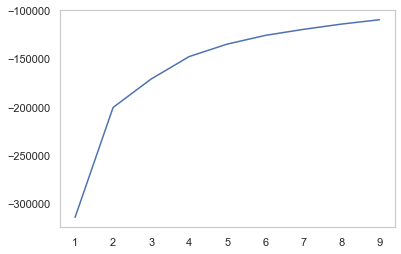

In [101]:
num_clusters = range(1,10)
score = compute_heterogeneity(num_clusters, playlist_norm)

plt.plot(num_clusters, score)

The ideal number of clusters, k, appears to be either 2 or 4, based on the elbow chart. Let's choose 4 to have more groups to segment our data

#### Run k-means with chosen number of clusters

In [21]:
def kmeans(num_clusters, data):
    '''Runs kmeans algorithm, returning cluster assignment and centers'''
    # Initialize KMeans
    kmeans = KMeans(n_clusters=num_clusters)

    # Fitting with inputs
    kmeans = kmeans.fit(data)

    # Predicting clusters
    labels = kmeans.predict(data)

    # Get cluster centers
    centers = kmeans.cluster_centers_
    
    return labels, centers

In [22]:
def build_kmeans_output(data, col_name):
    '''Builds out final dataset'''
    df_means[col_name] = data.groupby(['cluster'])[col_name].mean().to_frame(col_name)    

In [23]:
def run_kmeans(df, clusters):
    # Run kmeans, given a specified number of clusters
    data = df.copy()
    labels, centers = kmeans(clusters, data.drop("trackid", axis=1))
    data['cluster'] = labels
    
    # Build df_means table to store results
    df_means = data.groupby(['cluster'])['trackid'].count().to_frame('n')
    
    for col in data.columns.values:
        if col != 'trackid':
            df_means[col] = data.groupby(['cluster'])[col].mean().to_frame(col)    
      
    # Generate alphabetical representation of clusters
    mapping = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6: 'G', 7:'H', 8:'I', 9:'K'}
    df_means['cluster_alpha'] = df_means['cluster']
    df_means = df_means.replace({'cluster_alpha':mapping})

    data['cluster_alpha'] = data['cluster']
    data = data.replace({'cluster_alpha':mapping})
    
    return df_means, data

In [24]:
k = 10
playlist_norm["trackid"] = playlist_norm.index
playlist_means, playlist_clusters = run_kmeans(playlist_norm, k)
playlist_means

,n,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster,cluster_alpha
cluster,,,,,,,,,,,,,,,,
0,4680,0.527606,0.381609,0.502137,0.786160,0.0,0.084527,0.685467,0.196106,0.150752,0.324972,0.457480,0.054522,0.774786,0,A
1,11876,0.610440,0.657325,0.127522,0.870251,1.0,0.113429,0.092211,0.016058,0.198712,0.314392,0.499386,0.054493,0.791647,1,B
2,15905,0.664332,0.701859,0.801892,0.873891,0.0,0.131369,0.114995,0.047631,0.197132,0.527045,0.494377,0.053648,0.795008,2,C
3,11888,0.571887,0.676986,0.730691,0.873021,1.0,0.089759,0.098877,0.020912,0.189141,0.325690,0.500308,0.055065,0.788896,3,D
4,12070,0.679382,0.744036,0.124403,0.877629,1.0,0.102335,0.134268,0.015675,0.191117,0.717732,0.491456,0.050634,0.795775,4,E
5,6080,0.538091,0.371423,0.140580,0.805238,1.0,0.066456,0.704605,0.022081,0.165631,0.384326,0.472610,0.052322,0.765395,5,F
6,6575,0.540072,0.374799,0.704141,0.806942,1.0,0.069360,0.702925,0.020153,0.173699,0.413657,0.465761,0.050915,0.762586,6,G
7,14106,0.675669,0.737711,0.716014,0.877368,1.0,0.102755,0.150822,0.014263,0.193497,0.722722,0.495362,0.050421,0.793294,7,H
8,3009,0.503101,0.522950,0.421916,0.786540,1.0,0.059363,0.403975,0.816638,0.165707,0.333179,0.477168,0.057833,0.775474,8,I


In [25]:
playlist_clusters.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,trackid,cluster,cluster_alpha
trackid,,,,,,,,,,,,,,,,
spotify:track:0qgiFuYhYuwtFXEwYakddE,0.513158,0.683,0.636364,0.846418,1.0,0.032746,0.304217,0.000132,0.142570,0.901,0.385987,0.070639,0.8,spotify:track:0qgiFuYhYuwtFXEwYakddE,7,H
spotify:track:0wzABO1igQsSy8cQ7dIeHK,0.487854,0.800,1.000000,0.826872,0.0,0.094922,0.057129,0.002230,0.388554,0.569,0.640314,0.045637,0.8,spotify:track:0wzABO1igQsSy8cQ7dIeHK,2,C
spotify:track:4dzOxPZFYX77xpMwv4EhnO,0.409919,0.910,0.818182,0.892798,1.0,0.132642,0.000501,0.000000,0.074197,0.641,0.792052,0.040098,0.8,spotify:track:4dzOxPZFYX77xpMwv4EhnO,7,H
spotify:track:2rnvHrNnkWMcAkl4S1WlRg,0.698381,0.373,0.000000,0.824003,0.0,0.029430,0.724900,0.001030,0.111446,0.329,0.471436,0.071987,0.8,spotify:track:2rnvHrNnkWMcAkl4S1WlRg,0,A
spotify:track:56twMOlq9DJc3EgpVUVIrW,0.417004,0.472,0.727273,0.855156,1.0,0.049326,0.476908,0.000000,0.097791,0.327,0.561735,0.043108,0.6,spotify:track:56twMOlq9DJc3EgpVUVIrW,6,G


#### Visualize attributes across clusters

In [26]:
def plot_bar_by_cluster(df, cols):
    sns.set(style="whitegrid")

    # Draw a nested barplot 
    chart = sns.catplot(x=cols[0], y=cols[1], data=df[cols],
                    height=6, kind="bar", palette="Blues_r")
    chart.despine(left=True)
    chart.set_ylabels(cols[1])
    chart.set_xlabels(cols[0])
    plt.title(f"""Mean {cols[1]} by cluster"""); 

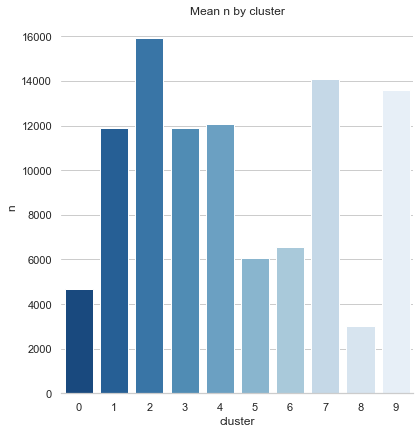

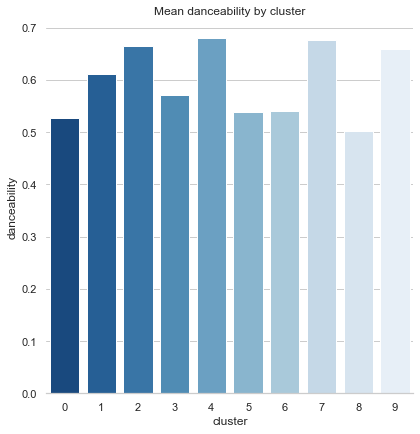

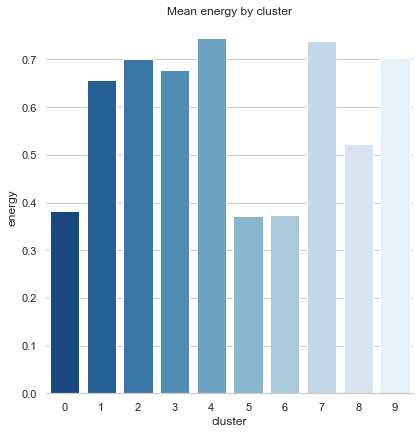

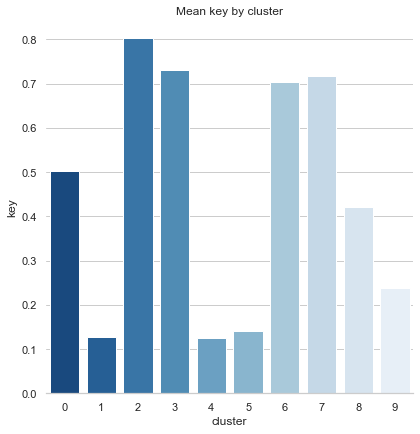

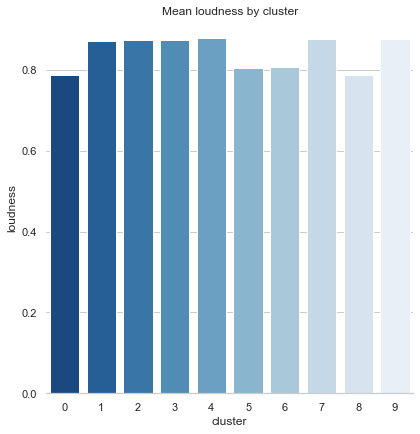

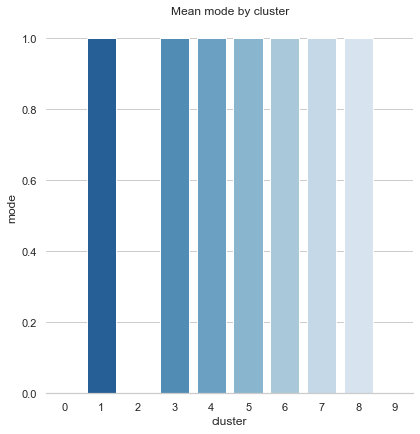

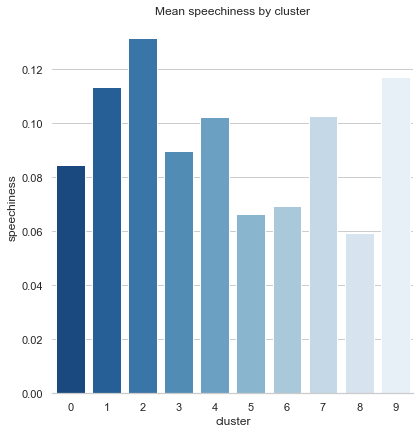

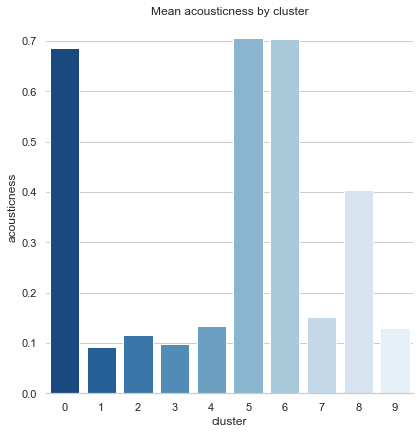

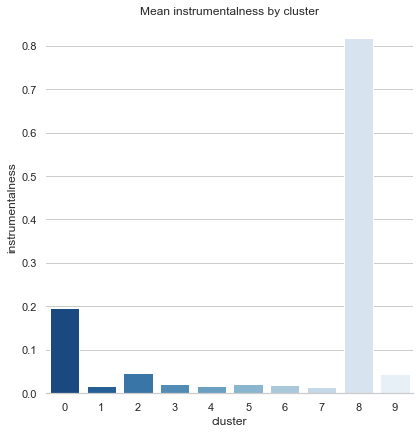

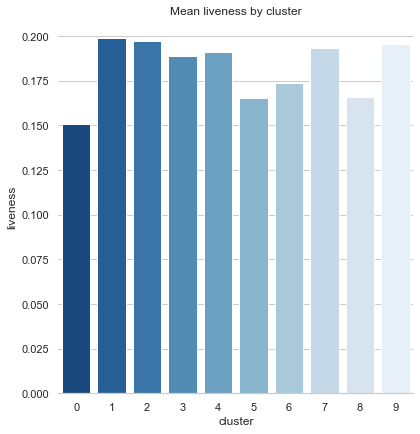

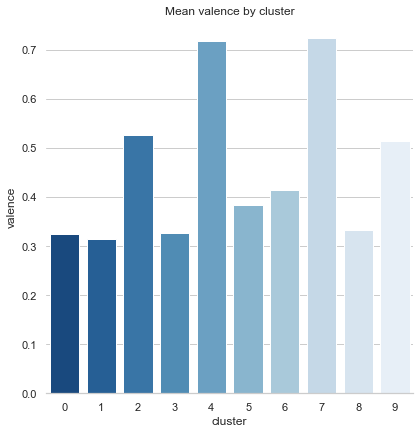

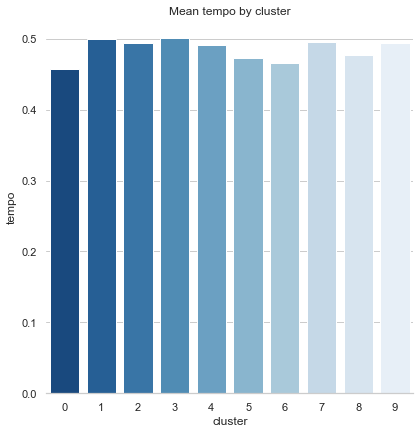

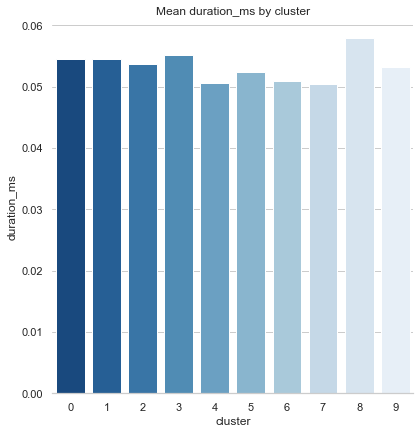

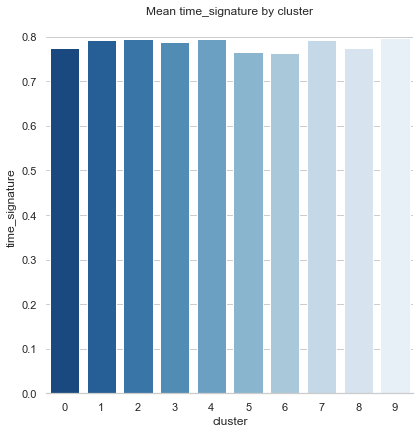

In [27]:
features = ['n','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
           'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
           'duration_ms', 'time_signature']

for feature in features:
    cols = ["cluster"]
    cols.append(feature)
    plot_bar_by_cluster(playlist_means, cols)

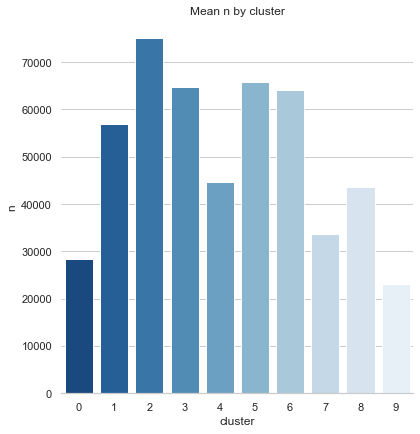

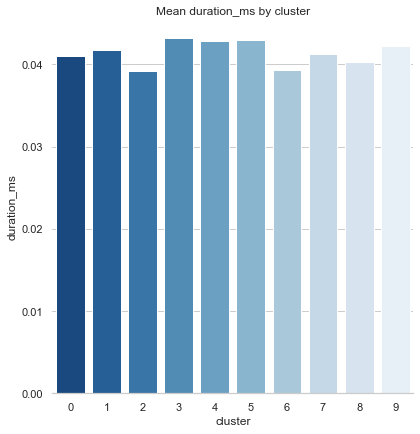

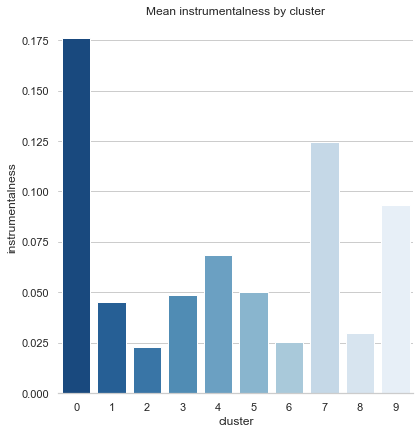

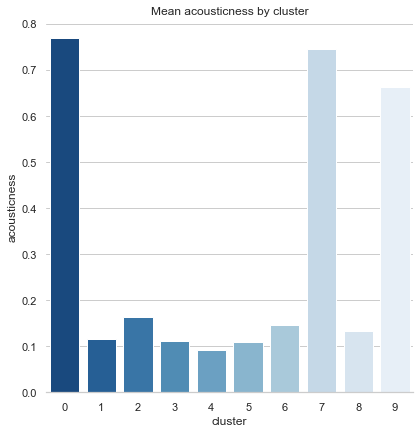

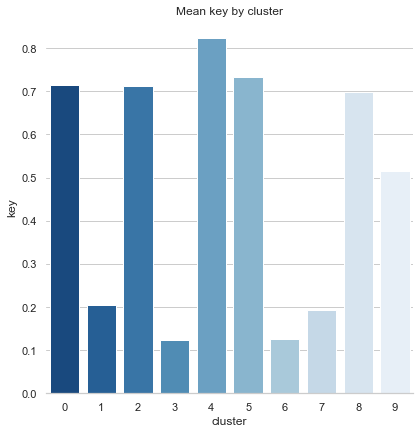

In [201]:
writeup_features = ['n', 'duration_ms', 'instrumentalness', 'acousticness', 'key']

for feature in writeup_features:
    cols = ["cluster"]
    cols.append(feature)
    plot_bar_by_cluster(playlist_means, cols)

#### K-Nearest Neighbors

Great, now that we have labels for our tracks (cluster number), we can build a recommender engine. Let's use K-Nearest neighbors to fit future songs to a given cluster. First, we need to split our data into train and test.

In [28]:
playlist_clusters = playlist_clusters.drop(["trackid", "cluster"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(playlist_clusters.loc[:, playlist_clusters.columns != 'cluster_alpha'], 
                                                    playlist_clusters.cluster_alpha, test_size=0.2, 
                                                    random_state = 666, 
                                                    stratify = playlist_clusters.cluster_alpha)

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((79811, 13), (19953, 13), (79811,), (19953,))

Now, train our knn model using Cross-Validation

In [30]:
ks = [2, 5, 7, 10, 20, 25, 50, 100]
output = []

for k in ks:
    # https://towardsdatascience.com/building-a-k-nearest-neighbors-k-nn-model-with-scikit-learn-51209555453a
    print(f'''**************************************'''
          f'''\nRunning kNN classification for k={k}''')
    knn_cv = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn_cv, X_train, y_train, cv=5)
    output.append({"k": k, "cv_scores_mean": np.mean(cv_scores)})
    print(f'''cv_scores: {cv_scores}''')
    print(f'''cv_scores mean: {np.mean(cv_scores)}''')


**************************************
Running kNN classification for k=2
cv_scores: [0.96229251 0.96134812 0.96090715 0.96372635 0.96071182]
cv_scores mean: 0.9617971922041096
**************************************
Running kNN classification for k=5
cv_scores: [0.96517382 0.96429243 0.96178424 0.96579376 0.96271696]
cv_scores mean: 0.9639522407844534
**************************************
Running kNN classification for k=7
cv_scores: [0.96398371 0.96473094 0.96197218 0.96529257 0.96221568]
cv_scores mean: 0.963639017227786
**************************************
Running kNN classification for k=10
cv_scores: [0.96335734 0.96335275 0.96046861 0.96491668 0.96121311]
cv_scores mean: 0.9626616992173908
**************************************
Running kNN classification for k=20
cv_scores: [0.95978703 0.95921819 0.95827591 0.96197218 0.96071182]
cv_scores mean: 0.9599930278934679
**************************************
Running kNN classification for k=25
cv_scores: [0.9621046  0.95984464 0.958

In [31]:
pd.DataFrame(output)

,k,cv_scores_mean
0,2,0.961797
1,5,0.963952
2,7,0.963639
3,10,0.962662
4,20,0.959993
5,25,0.960081
6,50,0.960507
7,100,0.964804


In [32]:
# Idk.. let's choose 100?
neighbors = 100
knn_chosen = KNeighborsClassifier(n_neighbors=neighbors).fit(X_train, y_train)
knn_chosen_predictions_train = knn_chosen.predict(X_train)
knn_chosen_predictions_test = knn_chosen.predict(X_test)

In [33]:
def report_accuracy_and_misclassification(y_train, y_test, predictions_train, predictions_test):
    print(f'''Accuracy score on training data: '''
          f'''{accuracy_score(y_train, predictions_train)}''')

    print(f'''Misclassification rate on training data: '''
          f'''{1 - accuracy_score(y_train, predictions_train)}''')

    print(f'''Accuracy score on test data: '''
          f'''{accuracy_score(y_test, predictions_test)}''')

    print(f'''Misclassification rate on test data: '''
          f'''{1 - accuracy_score(y_test, predictions_test)}''')
            

In [34]:
report_accuracy_and_misclassification(y_train, 
                                      y_test, 
                                      knn_chosen_predictions_train, 
                                      knn_chosen_predictions_test)

Accuracy score on training data: 0.9667589680620465
Misclassification rate on training data: 0.03324103193795347
Accuracy score on test data: 0.9636144940610435
Misclassification rate on test data: 0.03638550593895651


In [81]:
# double check predictions vs true
y_train_np = y_train.reset_index().drop("trackid", axis=1)["cluster_alpha"].to_numpy()
df_results = pd.DataFrame(y_train_np, columns=["y_true"])
df_results["y_hat"] = knn_chosen_predictions_train
df_results

,y_true,y_hat
0,C,C
1,G,D
2,B,B
3,B,B
4,D,D
...,...,...
79806,E,E
79807,K,K
79808,G,G
79809,C,C


#### Make Predictions With K-Nearest Neighbors
Now that we have a model, selected using cross-validation, we can predict class labels. Can we also get closest song? Return a list of *n* closest songs in terms of feature vector distance

The second song in our X_test data is John Mayer's "Only Heart". Let's classify it into its appropriate cluster.

In [125]:
X_test.index[1]

'spotify:track:3Ngl8Fn5UtCl2K7UD7EF9e'

In [132]:
playlist_data.iloc[playlist_data.index[playlist_data["trackid"] == X_test.index[1]]]

,unique_pid,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,album_name,index,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,trackid
7468,999113,113,95,John Mayer,spotify:track:3Ngl8Fn5UtCl2K7UD7EF9e,spotify:artist:0hEurMDQu99nJRq8pTxO14,Only Heart,spotify:album:6WivmTXugLZLmAWnZhlz7g,Heavier Things,14.0,...,0.949,120.942,audio_features,3Ngl8Fn5UtCl2K7UD7EF9e,spotify:track:3Ngl8Fn5UtCl2K7UD7EF9e,https://api.spotify.com/v1/tracks/3Ngl8Fn5UtCl...,https://api.spotify.com/v1/audio-analysis/3Ngl...,228907.0,4.0,spotify:track:3Ngl8Fn5UtCl2K7UD7EF9e
72410,997239,239,77,John Mayer,spotify:track:3Ngl8Fn5UtCl2K7UD7EF9e,spotify:artist:0hEurMDQu99nJRq8pTxO14,Only Heart,spotify:album:6WivmTXugLZLmAWnZhlz7g,Heavier Things,14.0,...,0.949,120.942,audio_features,3Ngl8Fn5UtCl2K7UD7EF9e,spotify:track:3Ngl8Fn5UtCl2K7UD7EF9e,https://api.spotify.com/v1/tracks/3Ngl8Fn5UtCl...,https://api.spotify.com/v1/audio-analysis/3Ngl...,228907.0,4.0,spotify:track:3Ngl8Fn5UtCl2K7UD7EF9e


Our model predicts this song will be in Cluster D

In [144]:
knn_chosen.predict(X_test.iloc[:1].to_numpy())

array(['D'], dtype=object)

In [160]:
# These are the indices of the 100 closest neighbors to John Mayer's "Only Heart"
kneighbors_indices = knn_chosen.kneighbors(X_test.iloc[:1].to_numpy())[1].reshape(-1)

In [195]:
# Let's get the track info for these 100
playlist_data[playlist_data["trackid"].isin(X_train.ix[kneighbors_indices].index)]\
    [["trackid", "artist_name", "track_name"]]

/Users/austinrochon/Documents/6.Harvard/harvard-coursework/ac209a/labs/lab1/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


,trackid,artist_name,track_name
1081,spotify:track:1pVfFIMl22irgWpMxZWdFa,Dennis Kruissen,Falling In Love
1264,spotify:track:5n2gLWtpzsekIh3j6CMevy,VNCHY,Not Sure
1690,spotify:track:3eytMjOdgSIFEUBJP6dujB,Shane & Shane,Man of Sorrows
2945,spotify:track:5kIcrM3QVD4BQPFMszQnU1,Jesse & Joy,¡Corre!
3796,spotify:track:5brMyscUnQg14hMriS91ks,The Chainsmokers,Kanye
...,...,...,...
97150,spotify:track:5brMyscUnQg14hMriS91ks,The Chainsmokers,Kanye
97639,spotify:track:6ISIGB6G6cPVwqBEW2ELis,Lo Moon,Loveless - Edit
98487,spotify:track:0Y56O7F1yiuoYyCGrgLpJY,Brian Johnson,Greatness of Your Glory (Live)
98490,spotify:track:1ed3wNCecRIp6SugyR0w2J,Hillsong United,So Will I (100 Billion X)
